Action items
* Check tsne loss
* Do you need a more specific SentenceTransformer?
* How many nearby neighbors do you have to train on? Maybe the dataset is just too scattered. Let's say you have only 3 examples to train on. Even if you apply regularization, most likely that's not enough samples to train on.
* Another question is - rouge is much worse on the validation set. In a general sense, this may be okay, but in a more specific sense, for this dataset, I think it often means incorrect information.
    * Check rouge distribution?
    * Yeah, even for the training and validation samples with closest distance, the inference is not good for validation
        * Sanity-check the text for fracture or broken to see if there are any other close examples
* There are also samples that contain almost no information
* Check for nearest samples across the entire dataset (not just train) - yup, there are only 3 total samples in the vicinity
    * IDs: 727 (train), 209 and 649 (val)

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, re
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances

In [2]:
ds = load_dataset("ryanwtsai/MTS_Dialogue-Clinical_Note_TrainValTestSplit")
ds

DatasetDict({
    train: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 1040
    })
    val: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 132
    })
    test: Dataset({
        features: ['ID', 'section_header', 'section_text', 'dialogue', 'input_ids', 'attention_mask', 'length', 'labels'],
        num_rows: 128
    })
})

In [3]:
df = {key: pd.DataFrame(value) for key, value in ds.items()}

In [4]:
# model = SentenceTransformer("all-mpnet-base-v2") # max seq len = 384
model = SentenceTransformer("all-distilroberta-v1")

C:\ProgramData\anaconda3\envs\env_dl_cv_transformer_sentpiece\Lib\site-packages\huggingface_hub\file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Encodings

In [5]:
# Remove samples longer than max sequence length of the SentenceTransformer

threshold = model.max_seq_length
for key in df:
    df[key] = df[key].loc[df[key]['length'] <= threshold, :]
    df[key]['output_length'] = df[key]['labels'].apply(lambda x: len(x))

In [6]:
# for key in df:
#     print(key + ":")
#     print(df[key]['length'].describe())
#     print(df[key]['output_length'].describe())
#     print("-------------------------------------------------")

In [7]:
# Get SentenceTransformer embeddings for dialogue and summary

embeddings = {key: model.encode(list(df[key]['dialogue'])) for key in df}
embeddings_out = {key: model.encode(list(df[key]['section_text'])) for key in df}

In [8]:
num_samples = {key: embeddings[key].shape[0] for key in embeddings}
for key in embeddings:
    print(f"{key}: {embeddings[key].shape}, {embeddings_out[key].shape}")
print(num_samples)

train: (998, 768), (998, 768)
val: (127, 768), (127, 768)
test: (121, 768), (121, 768)
{'train': 998, 'val': 127, 'test': 121}


In [9]:
# Concatenate embeddings to pass to t-SNE

embeddings_all = np.concatenate((embeddings['train'], embeddings['val'], embeddings['test']))
embeddings_out_all = np.concatenate((embeddings_out['train'], embeddings_out['val'], embeddings_out['test']))
print(embeddings_all.shape)
print(embeddings_out_all.shape)

(1246, 768)
(1246, 768)


In [11]:
# Apply t-SNE to dialogue and summary embeddings

tsne = TSNE(perplexity=10)
embeddings_all_tsne = tsne.fit_transform(embeddings_all)
kl_div = tsne.kl_divergence_
embeddings_out_all_tsne = tsne.fit_transform(embeddings_out_all)
kl_div_out = tsne.kl_divergence_
print(embeddings_all_tsne.shape)
print(embeddings_out_all_tsne.shape)
print(kl_div)
print(kl_div_out)

(1246, 2)
(1246, 2)
1.4601633548736572
1.3758314847946167


In [14]:
# Split the t-SNE output back into train/val/test splits

embeddings_tsne = {}
embeddings_out_tsne = {}
embeddings_tsne['train'] = embeddings_all_tsne[:num_samples['train'], :]
embeddings_tsne['val'] = embeddings_all_tsne[num_samples['train']:num_samples['train']+num_samples['val'], :]
embeddings_tsne['test'] = embeddings_all_tsne[num_samples['train']+num_samples['val']:, :]
embeddings_out_tsne['train'] = embeddings_out_all_tsne[:num_samples['train'], :]
embeddings_out_tsne['val'] = embeddings_out_all_tsne[num_samples['train']:num_samples['train']+num_samples['val'], :]
embeddings_out_tsne['test'] = embeddings_out_all_tsne[num_samples['train']+num_samples['val']:, :]
print(f"embeddings_tsne_train.shape = {embeddings_tsne['train'].shape}")
print(f"embeddings_tsne_val.shape = {embeddings_tsne['val'].shape}")
print(f"embeddings_tsne_test.shape = {embeddings_tsne['test'].shape}")
print(f"embeddings_out_tsne_train.shape = {embeddings_out_tsne['train'].shape}")
print(f"embeddings_out_tsne_val.shape = {embeddings_out_tsne['val'].shape}")
print(f"embeddings_out_tsne_test.shape = {embeddings_out_tsne['test'].shape}")

embeddings_tsne_train.shape = (998, 2)
embeddings_tsne_val.shape = (127, 2)
embeddings_tsne_test.shape = (121, 2)
embeddings_out_tsne_train.shape = (998, 2)
embeddings_out_tsne_val.shape = (127, 2)
embeddings_out_tsne_test.shape = (121, 2)


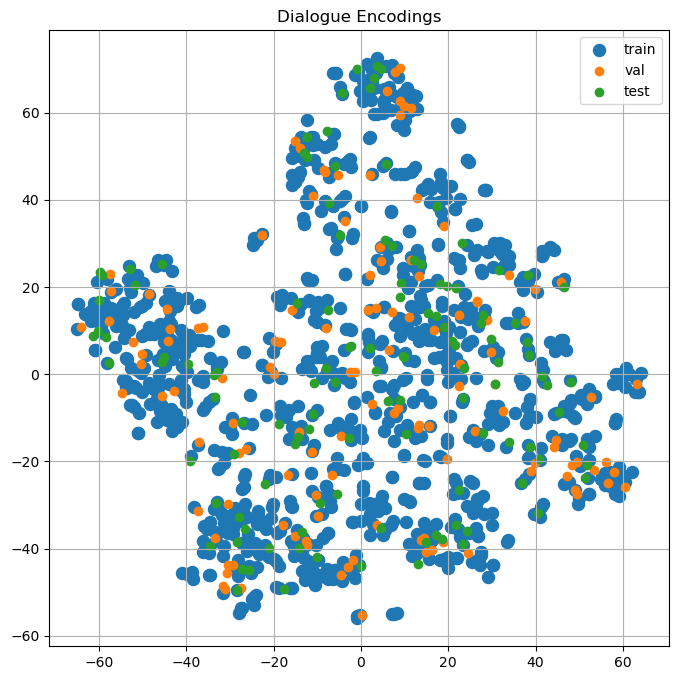

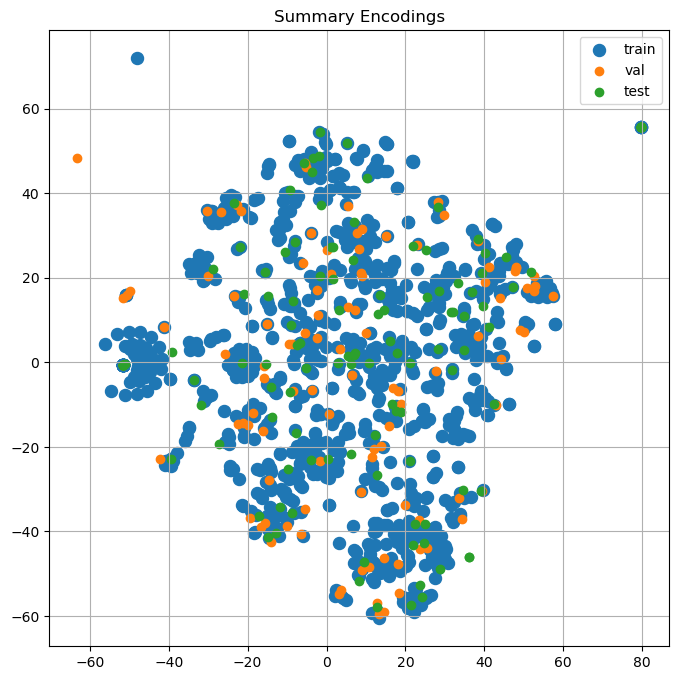

In [15]:
# Plot t-SNE results

plt.figure(figsize=(8,8))
plt.scatter(embeddings_tsne['train'][:, 0], embeddings_tsne['train'][:, 1], s=75, label="train")
plt.scatter(embeddings_tsne['val'][:, 0], embeddings_tsne['val'][:, 1], label="val")
plt.scatter(embeddings_tsne['test'][:, 0], embeddings_tsne['test'][:, 1], label="test")
plt.title("Dialogue Encodings")
plt.legend()
plt.grid()

plt.figure(figsize=(8,8))
plt.scatter(embeddings_out_tsne['train'][:, 0], embeddings_out_tsne['train'][:, 1], s=75, label="train")
plt.scatter(embeddings_out_tsne['val'][:, 0], embeddings_out_tsne['val'][:, 1], label="val")
plt.scatter(embeddings_out_tsne['test'][:, 0], embeddings_out_tsne['test'][:, 1], label="test")
plt.title("Summary Encodings")
plt.legend()
plt.grid()

In [19]:
# For each sample in val, find the top_k closest samples from train

def get_closest_training_samples(val, train, metric="euclidean", top_k=5):
    distances = pairwise_distances(val, train, metric=metric)
    nearest_train = np.argsort(distances, axis=1)[:, :top_k]
    nearest_dist = np.take_along_axis(distances, nearest_train, axis=1)

    # Each row corresponds to a validation sample
    # Columns are the closest training sample indices and distances
    return nearest_train, nearest_dist

In [72]:
# First, check validation samples against training samples

top_k = 10
data_split_to_compare = 'val'

if data_split_to_compare == 'val':
    top_k += 1
nearest_train, nearest_dist = get_closest_training_samples(embeddings_tsne['val'], embeddings_tsne[data_split_to_compare], top_k=top_k)
nearest_train_out, nearest_dist_out = get_closest_training_samples(embeddings_out_tsne['val'], embeddings_out_tsne[data_split_to_compare], top_k=top_k)
if data_split_to_compare == 'val':
    nearest_train = nearest_train[:, 1:]
    nearest_dist = nearest_dist[:, 1:]
    nearest_train_out = nearest_train_out[:, 1:]
    nearest_dist_out = nearest_dist_out[:, 1:]
print(nearest_train.shape)
print(nearest_train_out.shape)

(127, 10)
(127, 10)


# Check closest match b/w validation and training sample based on dialogue
### Interestingly, the closest matches to the validation sample based on dialogue and the closest matches to the validation sample based on summary only have one overlap: training sample @ index 810

In [73]:
# Find the validation sample that has the closest training sample match (based on dialogue)

val_sample = np.argmin(nearest_dist[:, 0])
val_sample = 63
print("Closest validation and training sample match by dialogue:")
print(f"Validation sample index = {val_sample}")
print(f"Closest training sample distances to validation sample = {nearest_dist[val_sample, :]}")
train_samples = nearest_train[val_sample, :]
print(f"Closest training samples to validation sample = {train_samples}")
train_samples_out = nearest_train_out[val_sample, :]
print(f"For the validation sample summary, closest training sample summaries = {train_samples_out}")
print(f"And their distances = {nearest_dist_out[val_sample, :]}")
print(f"Intersection of closest training samples by dialogue and by summary = {list(set(train_samples) & set(train_samples_out))}")

Closest validation and training sample match by dialogue:
Validation sample index = 63
Closest training sample distances to validation sample = [ 0.9487317  3.7076972  5.9355626  6.5061255  6.557679   7.7386684
  9.661412   9.949658  10.967191  11.038126 ]
Closest training samples to validation sample = [ 64 122  73 105  19  96  90  57  75 111]
For the validation sample summary, closest training sample summaries = [ 64  62   6 122  90  96  57  74 105  19]
And their distances = [ 1.2509435  8.587072  10.028642  10.264226  10.460315  11.103075
 11.370224  11.752738  13.48658   14.682172 ]
Intersection of closest training samples by dialogue and by summary = [64, 96, 122, 105, 19, 57, 90]


In [74]:
val_id = df['val'].iloc[val_sample]['ID']
train_ids = list(df['train'].iloc[train_samples]['ID'])
train_summ_ids = list(df['train'].iloc[train_samples_out]['ID'])
print(f"Validation sample ID = {val_id}")
print(f"Training sample IDs (by dialogue) = {train_ids}")
print(f"Training sample IDs (by summary) = {train_summ_ids}")

Validation sample ID = 209
Training sample IDs (by dialogue) = [94, 1170, 817, 1283, 770, 1005, 231, 407, 723, 609]
Training sample IDs (by summary) = [94, 7, 345, 1170, 231, 1005, 407, 486, 1283, 770]


## Check the closest training samples by dialogue
* Fractures, surgery, infection
* The summaries don't look that similar. Dialogue beyond the first few also don't look that similar.

In [75]:
print(f"Validation sample, ID = {df['val'].iloc[val_sample]['ID']}")
print('')
print(df['val'].iloc[val_sample]['dialogue'])
print('')
print(df['val'].iloc[val_sample]['section_text'])
print('--------------------------------------------------')

for train_sample in train_samples[:5]:
    print(f"Training sample, ID = {df[data_split_to_compare].iloc[train_sample]['ID']}")
    print('')
    print(df[data_split_to_compare].iloc[train_sample]['dialogue'])
    print('')
    print(df[data_split_to_compare].iloc[train_sample]['section_text'])
    print('--------------------------------------------------')
    

Validation sample, ID = 209

Doctor: Good morning, young man. Are these your parents?
Patient: Yes. 
Doctor: Good, can you tell me more about your son, please? 
Guest_family_1: Well, he's five now, and he fell onto his right arm on December fifth two thousand seven.
Doctor: After he fell, how was he treated? 
Guest_family_1: We went to the E D right after he fell, and they said he had complete fractures of both bones in the arm. 
Doctor: Yes, I see that here, he also has shortening bayonet apposition. 
Guest_family_1: What can we do for this? 
Doctor: There's actually a few options here. First we can cast it and see how he heals, generally, children heal up very well from fractures. 
Guest_family_1: That's good, we like that option more than any kind of surgery. 
Doctor: However, surgery is also an option here as well. 
Guest_family_1: Yeah, to be completely sure we fix this, I think we should opt for the surgery, what do you think, honey?
Guest_family_2: Yes, I agree. What are the ris

## Check the closest training samples by summary
* Arm, body parts, left/right

In [76]:
print(f"Validation sample, ID = {df['val'].iloc[val_sample]['ID']}")
print('')
print(df['val'].iloc[val_sample]['dialogue'])
print('')
print(df['val'].iloc[val_sample]['section_text'])
print('--------------------------------------------------')

for train_sample in train_samples_out[:5]:
    print(f"Training sample, ID = {df['train'].iloc[train_sample]['ID']}")
    print('')
    print(df[data_split_to_compare].iloc[train_sample]['dialogue'])
    print('')
    print(df[data_split_to_compare].iloc[train_sample]['section_text'])
    print('--------------------------------------------------')

Validation sample, ID = 209

Doctor: Good morning, young man. Are these your parents?
Patient: Yes. 
Doctor: Good, can you tell me more about your son, please? 
Guest_family_1: Well, he's five now, and he fell onto his right arm on December fifth two thousand seven.
Doctor: After he fell, how was he treated? 
Guest_family_1: We went to the E D right after he fell, and they said he had complete fractures of both bones in the arm. 
Doctor: Yes, I see that here, he also has shortening bayonet apposition. 
Guest_family_1: What can we do for this? 
Doctor: There's actually a few options here. First we can cast it and see how he heals, generally, children heal up very well from fractures. 
Guest_family_1: That's good, we like that option more than any kind of surgery. 
Doctor: However, surgery is also an option here as well. 
Guest_family_1: Yeah, to be completely sure we fix this, I think we should opt for the surgery, what do you think, honey?
Guest_family_2: Yes, I agree. What are the ris

# Look for mentions of "fracture(s/d)"

In [89]:
pattern = r"\b(fracture(s|d)?|surgery|surgeries)\b"
pattern = r"\bfracture(s|d)?\b"
# pattern = r"\b(surgery|surgeries)\b"

In [91]:
df_filter = {}
column_to_search = 'dialogue'
column_to_search = 'section_text'
for key in df:
    df_filter[key] = df[key][df[key][column_to_search].str.contains(pattern, case=False, regex=True)]
    print(f"Number of matches for {key} dataset = {len(df_filter[key])}")
    print(f"{key} IDs = {list(df_filter[key]['ID'])}")

Number of matches for train dataset = 7
train IDs = [652, 814, 1097, 398, 514, 902, 727]
Number of matches for val dataset = 3
val IDs = [209, 649, 640]
Number of matches for test dataset = 1
test IDs = [606]


C:\Users\Ryan Tsai\AppData\Local\Temp\ipykernel_25392\134024511.py:5: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filter[key] = df[key][df[key][column_to_search].str.contains(pattern, case=False, regex=True)]


In [92]:
for key in df_filter:
    for sdx in range(len(df_filter[key])):
        print(f"{key} dataset, ID = {df_filter[key].iloc[sdx, :]['ID']}")
        print('')
        print(df_filter[key].iloc[sdx, :]['dialogue'])
        print('')
        print(df_filter[key].iloc[sdx, :]['section_text'])
        print('------------------------------------------------------------')

train dataset, ID = 652

Doctor: We've been following you for several conditions for a while now. What seems to be the problem today, sir? 
Patient: Um, I was peeing blood, it's back again. 
Doctor: Did you do anything that could have provoked it to come back?
Patient: No, not that I know of. 
Doctor: Have you been taking the Flomax for your B P H? 
Patient: Yes, I have been. 
Doctor: What about the Coumadin?
Patient: Yes, I've been taking that too. It has been held recently, but I ususally take it.
Doctor: Remind me, I don't have my chart with me. What conditions have you been taking the Coumadin for?
Patient: I have A F I B and stroke.
Doctor: Thank you. Isn't this your second occurrence of gross hematuria this month?
Patient: Yes, doctor.  
Doctor: Are you sure you haven't experienced any falls or anything recently? 
Patient: Yeah, actually I fell about a week ago. 
Doctor: Where is your pain from that fall? 
Patient: It's in my butt and leg. 
Doctor: Have you had your x rays taken 